In this notebook, we train a model using more of Cellposes' pre- and post-processing functions

In [1]:
from import_images import getImages
import numpy as np
import torch
from cellpose import resnet_torch
from cellpose import transforms, dynamics
import cv2
import time
from unet_architecture import UNet
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.transforms as T
from torchmetrics.classification import BinaryJaccardIndex
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#import ezomero
#from omero_data import connect, extract_channel, progressbar

In [2]:
def get_pre_activations(image,cpnet):
    x = torch.from_numpy(image)
    downsample = cpnet.downsample(x)
    style = cpnet.make_style(downsample[-1])
    upsample = cpnet.upsample(style, downsample, cpnet.mkldnn)
    
    output = cpnet.output(upsample).squeeze(0)
    output = output.cpu().detach().numpy()
    output = np.float32(output)

    upsample = upsample.squeeze(0)
    upsample = upsample.cpu().detach().numpy()
    upsample = np.float32(upsample)
    return upsample, output

#validation_dataset = ImageDataset(val_images_tiled, val_ysm, val__upsamples, validation_images, n_mask_array, validation=True)


class ImageDataset(Dataset):
    def __init__(self, image, upsample, cellprob):
        self.image = image
        self.upsample = upsample
        self.cellprob = cellprob
    
        #self.image = self.image.to('cuda:0')
        #self.upsample = self.upsample.to('cuda:0')
        #self.cellprob = self.cellprob.to('cuda:0')

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        img = self.image[idx]
        upsample = self.upsample[idx]
        cellprob = self.cellprob[idx]

        #img = torch.from_numpy(img)
        #upsample = torch.from_numpy(upsample)
        #cellprob = torch.from_numpy(cellprob).float()
        return img, upsample, cellprob
    
class KD_loss(torch.nn.Module):
    def __init__(self, alpha, beta):
        super(KD_loss, self).__init__()
        self.alpha = alpha
        self.beta = beta

    def forward(self, y_32_pred, y_32_true, y_3_pred, y_3_true):

        #y_32_loss = 1 - F.cosine_similarity(y_32_true, y_32_pred, dim=1).mean()
        y_32_loss = torch.mean(y_32_true - y_32_pred)**2
        #print(y_32_loss)
        #y_32_loss = F.mse_loss(y_32_pred, y_32_true)

        flow_loss = F.mse_loss(y_3_pred[:,:2], y_3_true[:,:2])
        flow_loss /= 2

        y_3_true_map = F.sigmoid(y_3_true[:,2])
        #y_3_true_map = y_3_true[:,2]

        map_loss = F.binary_cross_entropy_with_logits(y_3_pred[:,2] ,y_3_true_map)
        y_3_loss = flow_loss + map_loss
        
        return y_32_loss * self.alpha, y_3_loss * self.beta


def trainEpoch(unet, train_loader, validation_loader, loss_fn, optimiser, scheduler, epoch_num, device, progress=True):
    time_start = time.time()
    
    unet.train()

    train_y_32_loss, train_map_loss, train_IoU = 0, 0, 0

    for image, upsample, cp_output in train_loader:

        #image, upsample, cp_output = image.float(), upsample.float(), cp_output.float() #cast to float32 (important for mps)

        if device is not None:
            (image, upsample, cp_output) = (image.to(device),upsample.to(device),cp_output.to(device)) # sending the data to the device (cpu or GPU)

        #image = image.unsqueeze(1)
        #y_16_pred, y_32_pred, map_pred = unet(image)
        y_32_pred, pred, style = unet(image)
        #flow_pred = pred[:,1:]
        map_pred = pred

        y_32_pred = y_32_pred.squeeze(1)
        map_pred = map_pred.squeeze(1)

        loss_32, loss_map = loss_fn(y_32_pred,  upsample, map_pred, cp_output) # calculate the loss of that prediction
        loss = loss_32 + loss_map
        train_y_32_loss += loss_32.item()
        train_map_loss += loss_map.item()

         # zero out the accumulated gradients

        #I want to get two losses, one for the 32-channel output and one for the 3-channel output
        #I then want to freeze certain channels before putting the losses backwards
        #unet.encoder.requires_grad = True #repetitive but just to be clear
        #unet.decoder.requires_grad = True
        #unet.head.requires_grad = False
        #loss_32.backward(retain_graph=True)

        
        #unet.encoder.requires_grad = False
        #unet.decoder.requires_grad = False
        #unet.head.requires_grad = True
        #loss_map.backward(retain_graph=True)
        
        loss.backward()
        #loss.backward()

        optimiser.step() # update model parameters
        optimiser.zero_grad()

        #IoU score
        jaccard = BinaryJaccardIndex(threshold=0.5).to(device)
        map_pred = F.sigmoid(map_pred)
        cp_output = F.sigmoid(cp_output)
        cp_output = torch.where(cp_output > 0.5, 1.0, 0.0)
        iou = jaccard(map_pred, cp_output)
        if not torch.isnan(iou):
            train_IoU += iou.item()
        else:
            train_IoU += 0

        del image
        del upsample
        del cp_output
        torch.cuda.empty_cache()

    if scheduler is not None:
        scheduler.step()

    train_y_32_loss, train_map_loss, train_IoU = train_y_32_loss/len(train_loader), train_map_loss/len(train_loader), train_IoU/len(train_loader)


    val_y_32_loss, val_map_loss, val_IoU = 0, 0, 0
    for image, upsample, cp_output in validation_loader:
        
        #image, upsample, cp_output = image.float(), upsample.float(), cp_output.float() #cast to float32 (important for mps)

        if device is not None:
            (image, upsample, cp_output) = (image.to(device),upsample.to(device),cp_output.to(device)) # sending the data to the device (cpu or GPU)

        #image = image.unsqueeze(1)
        y_32_pred, pred, style = unet(image)
        #flow_pred = pred[:,1:]
        map_pred = pred

        y_32_pred = y_32_pred.squeeze(1)
        map_pred = map_pred.squeeze(1)

        loss_32, loss_map = loss_fn(y_32_pred,  upsample, map_pred, cp_output) # calculate the loss of that prediction
        #loss = loss_32 + loss_map
        val_y_32_loss += loss_32.item()
        val_map_loss += loss_map.item()

        #IoU score
        jaccard = BinaryJaccardIndex(threshold=0.5).to(device)
        map_pred = F.sigmoid(map_pred)
        cp_output = F.sigmoid(cp_output)
        cp_output = torch.where(cp_output > 0.5, 1.0, 0.0)
        iou = jaccard(map_pred, cp_output)
        if not torch.isnan(iou):
            val_IoU += iou.item()
        else:
            val_IoU += 0

        del image
        del upsample
        del cp_output
        torch.cuda.empty_cache()

    val_y_32_loss, val_map_loss, val_IoU = val_y_32_loss/len(validation_loader), val_map_loss/len(validation_loader), val_IoU/len(validation_loader)
    
    #we might add displaying later on
    if progress:
        if epoch_num is None:
            print('Train 32 loss: ', train_y_32_loss,'Train map loss', train_map_loss, 'Train IoU', train_IoU, 'Val 32 loss: ', val_y_32_loss, 'Val map loss: ', val_map_loss, 'Val IoU: ', val_IoU, 'Time: ', time.time()-time_start)
        else:
            print('Epoch: ', epoch_num, 'Train 32 loss: ', train_y_32_loss,'Train map loss', train_map_loss, 'Train IoU', train_IoU, 'Val 32 loss: ', val_y_32_loss, 'Val map loss: ', val_map_loss, 'Val IoU: ', val_IoU, 'Time: ', time.time()-time_start)
        
    torch.cuda.empty_cache()

    return unet, train_y_32_loss, train_map_loss, train_IoU, val_y_32_loss, val_map_loss, val_IoU

def get_omero_images_combined(num_images=None, channels=[0,0]):
    conn = connect(user='rz200',password='omeroreset')

    plate = 1237
    if num_images == None:
        image_ids = ezomero.get_image_ids(conn,plate=plate)
    else:
        image_ids = ezomero.get_image_ids(conn,plate=plate)[:num_images]

    print('In plate',plate,'we have',len(image_ids),'images')

   

    data_images = []
    for i in progressbar(range(len(image_ids)), "Computing: ", 40):
        data_images.append(ezomero.get_image(conn, image_ids[i])[1])

    if len(channels) == 2 and channels != [0,0]:
        data_images_one = extract_channel(data_images, channels[0])
        data_images_two = extract_channel(data_images, channels[1])

        combined_images = []
        for i in range(len(data_images_one)):
            combined_images.append(np.array([data_images_one[i] , data_images_two[i]]))
    
        return combined_images
    elif len(channels) == 1:
        data_images_one = extract_channel(data_images, channels[0])
        return data_images_one
    else:
        return data_images

def normalize_un(image):
    min_val = np.min(image)
    max_val = np.max(image)
    normalized_image = (image - min_val) / (max_val - min_val)
    return normalized_image

def normalize_all(images):
    min_val = np.min(images)
    max_val = np.max(images)
    normalized_images = (images - min_val) / (max_val - min_val)
    return normalized_images

def get_cellpose_data(cpnet, combined_images):
    images_tiled = []
    ys = []
    all_upsamples = []

    #combined_images = transforms.normalize_img(combined_images)

    for i in range(len(combined_images)):
        print(i)
        image_t = combined_images[i]


        if len(image_t.shape) == 2:
            image_t = [image_t,image_t]
            image_t = np.array(image_t)
        
        image_t = transforms.normalize_img(image_t)

        IMG, ysub, xsub, Ly, Lx = transforms.make_tiles(image_t, bsize=224, 
                                                        augment=True, tile_overlap=0.1)
        ny, nx, nchan, ly, lx = IMG.shape
        IMG = np.reshape(IMG, (ny*nx, nchan, ly, lx))
        images_tiled.append(IMG)
        batch_size = 1
        niter = int(np.ceil(IMG.shape[0] / batch_size))
        nout = 3 + 32*False
        y = np.zeros((IMG.shape[0], nout, ly, lx))
        styles = []

        upsamples = []

        for k in range(niter):
            irange = np.arange(batch_size*k, min(IMG.shape[0], batch_size*k+batch_size))
            upsample, y0 = get_pre_activations(IMG[irange], cpnet)
            upsamples.append(upsample)
            y[irange] = y0.reshape(len(irange), y0.shape[-3], y0.shape[-2], y0.shape[-1])

        ys.append(y)

        upsamples = np.array(upsamples)
        all_upsamples.append(upsamples)

    images_tiled_np = np.array(images_tiled)
    ys_np = np.array(ys)
    all_upsamples_np = np.array(all_upsamples)

    images_tiled_np = images_tiled_np.reshape(images_tiled_np.shape[0]*images_tiled_np.shape[1], images_tiled_np.shape[2], images_tiled_np.shape[3], images_tiled_np.shape[4])
    ys_np = ys_np.reshape(ys_np.shape[0]*ys_np.shape[1], ys_np.shape[2], ys_np.shape[3], ys_np.shape[4])
    all_upsamples_np = all_upsamples_np.reshape(all_upsamples_np.shape[0]*all_upsamples_np.shape[1], all_upsamples_np.shape[2], all_upsamples_np.shape[3], all_upsamples_np.shape[4])
        
    return images_tiled_np, ys_np, all_upsamples_np


In [3]:
from cellpose import utils
from tqdm import trange, tqdm
import logging

core_logger = logging.getLogger(__name__)
tqdm_out = utils.TqdmToLogger(core_logger, level=logging.INFO)

def pred(x, network, return_conv=False, return_training_data=False,channels=None):
    """ convert imgs to torch and run network model and return numpy """
    #X = x.to('cuda:0')
    X = x
    #self.net.eval()
    with torch.no_grad():
        if return_training_data == False:
            if channels == 1:
                X = X[:, 0, :, :]
                X = X.unsqueeze(1)
                y, style = network(X)
            else:
                y, style = network(X)
        else: 
            channel_32_output, final_output = network(X, training_data=True)
            return channel_32_output, final_output
    del X
    y = y.to('cuda:0')
    style = style.to('cuda:0')
    if return_conv:
        conv = conv.to('cuda:0')
        y = np.concatenate((y, conv), axis=1)
    
    return y, style
            

def run_tiled(imgi, network, augment=False, bsize=224, tile_overlap=0.1, return_conv=False, return_training_data=False,channels=None):
        """ run network in tiles of size [bsize x bsize]

        First image is split into overlapping tiles of size [bsize x bsize].
        If augment, tiles have 50% overlap and are flipped at overlaps.
        The average of the network output over tiles is returned.

        Parameters
        --------------

        imgi: array [nchan x Ly x Lx] or [Lz x nchan x Ly x Lx]

        augment: bool (optional, default False)
            tiles image with overlapping tiles and flips overlapped regions to augment

        bsize: int (optional, default 224)
            size of tiles to use in pixels [bsize x bsize]
         
        tile_overlap: float (optional, default 0.1)
            fraction of overlap of tiles when computing flows

        Returns
        ------------------

        yf: array [3 x Ly x Lx] or [Lz x 3 x Ly x Lx]
            yf is averaged over tiles
            yf[0] is Y flow; yf[1] is X flow; yf[2] is cell probability

        styles: array [64]
            1D array summarizing the style of the image, averaged over tiles

        """
        if not return_training_data:
            if imgi.ndim==4:
                batch_size = 8
                Lz, nchan = imgi.shape[:2]
                IMG, ysub, xsub, Ly, Lx = transforms.make_tiles(imgi[0], bsize=bsize, 
                                                                augment=augment, tile_overlap=tile_overlap)
                ny, nx, nchan, ly, lx = IMG.shape
                batch_size *= max(4, (bsize**2 // (ly*lx))**0.5)
                yf = np.zeros((Lz, network.nout, imgi.shape[-2], imgi.shape[-1]), np.float32)
                styles = []
                if ny*nx > batch_size:
                    ziterator = trange(Lz, file=tqdm_out)
                    for i in ziterator:
                        yfi, stylei = run_tiled(imgi[i], augment=augment, 
                                                    bsize=bsize, tile_overlap=tile_overlap)
                        yf[i] = yfi
                        styles.append(stylei)
                else:
                    # run multiple slices at the same time
                    ntiles = ny*nx
                    nimgs = max(2, int(np.round(batch_size / ntiles)))
                    niter = int(np.ceil(Lz/nimgs))
                    ziterator = trange(niter, file=tqdm_out)
                    for k in ziterator:
                        IMGa = np.zeros((ntiles*nimgs, nchan, ly, lx), np.float32)
                        for i in range(min(Lz-k*nimgs, nimgs)):
                            IMG, ysub, xsub, Ly, Lx = transforms.make_tiles(imgi[k*nimgs+i], bsize=bsize, 
                                                                            augment=augment, tile_overlap=tile_overlap)
                            IMGa[i*ntiles:(i+1)*ntiles] = np.reshape(IMG, (ny*nx, nchan, ly, lx))
                        ya, stylea = pred(IMGa, network, channels=channels)
                        for i in range(min(Lz-k*nimgs, nimgs)):
                            y = ya[i*ntiles:(i+1)*ntiles]
                            if augment:
                                y = np.reshape(y, (ny, nx, 3, ly, lx))
                                y = transforms.unaugment_tiles(y, network)
                                y = np.reshape(y, (-1, 3, ly, lx))
                            yfi = transforms.average_tiles(y, ysub, xsub, Ly, Lx)
                            yfi = yfi[:,:imgi.shape[2],:imgi.shape[3]]
                            yf[k*nimgs+i] = yfi
                            stylei = stylea[i*ntiles:(i+1)*ntiles].sum(axis=0)
                            stylei /= (stylei**2).sum()**0.5
                            styles.append(stylei)
                return yf, np.array(styles)
            else:
                IMG, ysub, xsub, Ly, Lx = transforms.make_tiles(imgi, bsize=bsize, 
                                                                augment=augment, tile_overlap=tile_overlap)
    
                ny, nx, nchan, ly, lx = IMG.shape
                IMG = np.reshape(IMG, (ny*nx, nchan, ly, lx))
                batch_size = 8
                niter = int(np.ceil(IMG.shape[0] / batch_size))
                nout = network.nout + 32*return_conv
                y = np.zeros((IMG.shape[0], nout, ly, lx))
                for k in range(niter):
                    irange = slice(batch_size*k, min(IMG.shape[0], batch_size*k+batch_size))
                    input_img = torch.from_numpy(IMG[irange])
                    y0, style = pred(input_img, network, return_training_data=False,channels=channels)
                    y0 = y0.cpu().detach().numpy()
                    style = style.cpu().detach().numpy()
                    y[irange] = y0.reshape(irange.stop-irange.start, y0.shape[-3], y0.shape[-2], y0.shape[-1])
                    if k==0:
                        styles = style[0]
                    styles += style.sum(axis=0)
                styles /= IMG.shape[0]
                if augment:
                    y = np.reshape(y, (ny, nx, nout, bsize, bsize))
                    y = transforms.unaugment_tiles(y, network)
                    y = np.reshape(y, (-1, nout, bsize, bsize))
                
                yf = transforms.average_tiles(y, ysub, xsub, Ly, Lx)
                yf = yf[:,:imgi.shape[1],:imgi.shape[2]]
                styles /= (styles**2).sum()**0.5
                return yf, styles
        else:
            tiles = []
            channel_32_outputs = []
            final_outputs = []
            IMG, ysub, xsub, Ly, Lx = transforms.make_tiles(imgi, bsize=bsize, 
                                                            augment=augment, tile_overlap=tile_overlap)

            ny, nx, nchan, ly, lx = IMG.shape
            IMG = np.reshape(IMG, (ny*nx, nchan, ly, lx))
            batch_size = 8
            niter = int(np.ceil(IMG.shape[0] / batch_size))
            nout = network.nout + 32*return_conv
            y = np.zeros((IMG.shape[0], nout, ly, lx))
            for k in range(niter):
                irange = slice(batch_size*k, min(IMG.shape[0], batch_size*k+batch_size))
                input_img = torch.from_numpy(IMG[irange])

                channel_32_output, final_output = pred(input_img, network, return_training_data=True)

                tiles.append(input_img)
                channel_32_outputs.append(channel_32_output)
                final_outputs.append(final_output)

            return tiles, channel_32_outputs, final_outputs


def run_net(imgs, network, augment=False, tile=True, tile_overlap=0.1, bsize=224,
                 return_conv=False,return_training_data=False,channels=None):
        """ run network on image or stack of images

        (faster if augment is False)

        Parameters
        --------------

        imgs: array [Ly x Lx x nchan] or [Lz x Ly x Lx x nchan]

        rsz: float (optional, default 1.0)
            resize coefficient(s) for image

        augment: bool (optional, default False)
            tiles image with overlapping tiles and flips overlapped regions to augment

        tile: bool (optional, default True)
            tiles image to ensure GPU/CPU memory usage limited (recommended);
            cannot be turned off for 3D segmentation

        tile_overlap: float (optional, default 0.1)
            fraction of overlap of tiles when computing flows

        bsize: int (optional, default 224)
            size of tiles to use in pixels [bsize x bsize]

        Returns
        ------------------

        y: array [Ly x Lx x 3] or [Lz x Ly x Lx x 3]
            y[...,0] is Y flow; y[...,1] is X flow; y[...,2] is cell probability

        style: array [64]
            1D array summarizing the style of the image,
            if tiled it is averaged over tiles

        """   
        if imgs.ndim==4:  
            # make image Lz x nchan x Ly x Lx for net
            imgs = np.transpose(imgs, (0,3,1,2)) 
            detranspose = (0,2,3,1)
            return_conv = False
        else:
            # make image nchan x Ly x Lx for net
            imgs = np.transpose(imgs, (2,0,1))
            detranspose = (1,2,0)

        # pad image for net so Ly and Lx are divisible by 4
        imgs, ysub, xsub = transforms.pad_image_ND(imgs)
        # slices from padding
#         slc = [slice(0, self.nclasses) for n in range(imgs.ndim)] # changed from imgs.shape[n]+1 for first slice size 
        slc = [slice(0, imgs.shape[n]+1) for n in range(imgs.ndim)]
        slc[-3] = slice(0, network.nout + 32*return_conv + 1)
        slc[-2] = slice(ysub[0], ysub[-1]+1)
        slc[-1] = slice(xsub[0], xsub[-1]+1)
        slc = tuple(slc)

        # run network
        if not return_training_data:
            if tile or augment or imgs.ndim==4:
                y, style = run_tiled(imgs, network=network, augment=augment, bsize=bsize, 
                                        tile_overlap=tile_overlap, 
                                        return_conv=return_conv,channels=channels)
            else:
                imgs = np.expand_dims(imgs, axis=0)
                y, style = network(imgs)
                y, style = y[0], style[0]
            style /= (style**2).sum()**0.5

            # slice out padding
            y = y[slc]
            # transpose so channels axis is last again
            y = np.transpose(y, detranspose)
            
            return y, style
        else:
            tiles, channel_32_outputs, final_outputs = run_tiled(imgs, network=network, augment=augment, bsize=bsize, 
                                        tile_overlap=tile_overlap, 
                                        return_conv=return_conv, return_training_data=return_training_data)
            return tiles, channel_32_outputs, final_outputs

def run_cp(x, network, compute_masks=True, normalize=True, invert=False,
            rescale=1.0, net_avg=False, resample=True,
            augment=False, tile=True, tile_overlap=0.1,
            cellprob_threshold=0.0, 
            flow_threshold=0.4, min_size=15,
            interp=True, anisotropy=1.0, do_3D=False, stitch_threshold=0.0,
            return_training_data=False,channels=None):
    
    tic = time.time()
    shape = x.shape
    print('shape:',shape)
    nimg = shape[0]        
    
    bd, tr = None, None
    #tqdm_out = utils.TqdmToLogger(models_logger, level=logging.INFO)
    #iterator = trange(nimg,file=tqdm_out) if nimg>1 else range(nimg)
    iterator = range(nimg)
    styles = np.zeros((nimg, network.nbase[-1]), np.float32)
    if resample:
        dP = np.zeros((2, nimg, shape[1], shape[2]), np.float32)
        cellprob = np.zeros((nimg, shape[1], shape[2]), np.float32)
        
    else:
        dP = np.zeros((2, nimg, int(shape[1]*rescale), int(shape[2]*rescale)), np.float32)
        cellprob = np.zeros((nimg, int(shape[1]*rescale), int(shape[2]*rescale)), np.float32)

    if not return_training_data:
        for i in iterator:
            img = np.asarray(x[i])
            if normalize or invert:
                img = transforms.normalize_img(img, invert=invert)
            if rescale != 1.0:
                img = transforms.resize_image(img, rsz=rescale)
            #yf, style = self._run_nets(img, net_avg=net_avg,
            #                            augment=augment, tile=tile,
            #                            tile_overlap=tile_overlap)

            yf, style = run_net(img, network=network, augment=augment, tile=tile, tile_overlap=0.1, bsize=224,
                    return_conv=False,channels=channels)
            if resample:
                yf = transforms.resize_image(yf, shape[1], shape[2])

            cellprob[i] = yf[:,:,2]
            dP[:, i] = yf[:,:,:2].transpose((2,0,1)) 
            if network.nout == 4:
                if i==0:
                    bd = np.zeros_like(cellprob)
                bd[i] = yf[:,:,3]
            styles[i] = style
        del yf, style
        styles = styles.squeeze()
        
        
        net_time = time.time() - tic

        if compute_masks:
            tic=time.time()
            niter = 200 if (do_3D and not resample) else (1 / rescale * 200)
            masks, p = [], []
            resize = [shape[1], shape[2]] if not resample else None
            use_gpu = torch.cuda.is_available()
            device = torch.device('cuda' if use_gpu else 'cpu')
            for i in iterator:
                outputs = dynamics.compute_masks(dP[:,i], cellprob[i], niter=niter, cellprob_threshold=cellprob_threshold,
                                                        flow_threshold=flow_threshold, interp=interp, resize=resize,
                                                        use_gpu=use_gpu, device=device)
                masks.append(outputs[0])
                p.append(outputs[1])
                
            masks = np.array(masks)
            p = np.array(p)
            
            if stitch_threshold > 0 and nimg > 1:
                masks = utils.stitch3D(masks, stitch_threshold=stitch_threshold)
                masks = utils.fill_holes_and_remove_small_masks(masks, min_size=min_size)
        
            flow_time = time.time() - tic
            masks, dP, cellprob, p = masks.squeeze(), dP.squeeze(), cellprob.squeeze(), p.squeeze()
            
        else:
            masks, p = np.zeros(0), np.zeros(0)  #pass back zeros if not compute_masks
        return masks, styles, dP, cellprob, p
    else:
        tiled_images_input = []
        intermdiate_outputs = []
        flows_and_cellprob_output = []
        for i in iterator:
            img = np.asarray(x[i])
            if normalize or invert:
                img = transforms.normalize_img(img, invert=invert)
            if rescale != 1.0:
                img = transforms.resize_image(img, rsz=rescale)
            #yf, style = self._run_nets(img, net_avg=net_avg,
            #                            augment=augment, tile=tile,
            #                            tile_overlap=tile_overlap)

            #need to return tiles, 32_channel output and flow with cellprob
            tiles, channel_32_outputs, final_outputs = run_net(img, network=network, augment=augment, tile=tile, tile_overlap=0.1, bsize=224,
                    return_conv=False, return_training_data=True)
            tiled_images_input.append(tiles)
            intermdiate_outputs.append(channel_32_outputs)
            flows_and_cellprob_output.append(final_outputs)
        return tiled_images_input, intermdiate_outputs, flows_and_cellprob_output

In [65]:
directory = "/Users/rz200/Documents/development/distillCellSegTrack/pipeline/CellPose_models/Nuclei_Hoechst"
cpnet = resnet_torch.CPnet(nbase=[2,32,64,128,256],nout=3,sz=3)
cpnet.load_model(directory)

In [48]:
print(cpnet.nbase,cpnet.nout,cpnet.batch_size)

AttributeError: 'CPnet' object has no attribute 'batch_size'

In [45]:
print(combined_images[0].shape)

(2, 1080, 1080)


In [166]:
x = np.array([combined_images[0][1]])
#if there is only one channel, copy the channel to make it 2 channels
if x.shape[0] == 1:
    x = np.repeat(x, 2, axis=0)
if x.ndim < 4:
    x = x[np.newaxis,...]
x = x.transpose((0,2,3,1))
masks, styles, dP, cellprob, p = run_cp(x,cpnet,rescale=1.283732)

shape: (1, 1080, 1080, 2)


In [363]:
torch.manual_seed(4)
from resnet_archi import CPnet
#unet = UNet(encChannels=(2,32,64,128,256),decChannels=(256,128,64,32),nbClasses=3) #it's not a problem to train it with 2 channels as anyway it is just the same channel repeated twice for the nuclei model but that may make more parameters to train so we may want to chang ethat
#unet = unet.to('cuda:0')
unet = CPnet(nbase=[2,32,64,128,256], nout=3, sz=3,
                residual_on=True, style_on=True, 
                concatenation=False, mkldnn=False)
unet.load_model(directory)
#unet = unet.to('cuda:0')

In [365]:
def get_cp_data_deconstructed(cpnet, combined_images):
    x = np.array([combined_images[1]])
    #if there is only one channel, copy the channel to make it 2 channels
    if x.shape[0] == 1:
        x = np.repeat(x, 2, axis=0)
    if x.ndim < 4:
        x = x[np.newaxis,...]
    x = x.transpose((0,2,3,1))
    tiled_images_input, intermdiate_outputs, flows_and_cellprob_output = run_cp(x,cpnet,rescale=1.283732,return_training_data=True)

    return tiled_images_input, intermdiate_outputs, flows_and_cellprob_output

def get_clean_train_data(tiled_images_input, intermdiate_outputs, flows_and_cellprob_output):
    tiled_images_input_train = tiled_images_input.copy()
    tiled_images_input_train_clean = []

    for i in range(8):
        # Remove the channel at dimension 1
        tiles = np.delete(tiled_images_input_train[0][i], 1, 1)
        tiles = np.squeeze(tiles)
        
        for tile in tiles:
            tiled_images_input_train_clean.append(tile)
    tiled_images_input_train_clean = torch.cat(tiled_images_input_train_clean)
    tiled_images_input_train_clean = tiled_images_input_train_clean.reshape(-1, 224, 224)

    tiled_intermediate_outputs_train = intermdiate_outputs.copy()
    tiled_intermediate_outputs_train_clean = []

    for i in range(8):
        #tiles = np.delete(tiled_intermediate_outputs_train[0][i], 1, 1)
        tiles = np.squeeze(tiled_intermediate_outputs_train[0][i])
        
        for tile in tiles:
            tiled_intermediate_outputs_train_clean.append(tile)

    tiled_intermediate_outputs_train_clean = torch.stack(tiled_intermediate_outputs_train_clean)

    tiled_flows_and_cellprob_output_train = flows_and_cellprob_output.copy()
    tiled_flows_and_cellprob_output_train_clean = []

    for i in range(8):
        #tiles = np.delete(tiled_intermediate_outputs_train[0][i], 1, 1)
        tiles = np.squeeze(tiled_flows_and_cellprob_output_train[0][i])
        
        for tile in tiles:
            tiled_flows_and_cellprob_output_train_clean.append(tile)

    tiled_flows_and_cellprob_output_train_clean = torch.stack(tiled_flows_and_cellprob_output_train_clean)

    return tiled_images_input_train_clean, tiled_intermediate_outputs_train_clean, tiled_flows_and_cellprob_output_train_clean


In [375]:
def get_data_cp_clean(unet,combined_images):
    tiled_images_final = []
    intermediate_outputs_final = []
    flows_and_cellprob_output_final = []

    for i in range(len(combined_images)):
        tiled_images_input, intermdiate_outputs, flows_and_cellprob_output = get_cp_data_deconstructed(unet, combined_images[0])
        tiled_images_input_train_clean, tiled_intermediate_outputs_train_clean, tiled_flows_and_cellprob_output_train_clean = get_clean_train_data(tiled_images_input, intermdiate_outputs, flows_and_cellprob_output)
        tiled_images_final.append(tiled_images_input_train_clean)
        intermediate_outputs_final.append(tiled_intermediate_outputs_train_clean)
        flows_and_cellprob_output_final.append(tiled_flows_and_cellprob_output_train_clean)
    
    tiled_images_final = torch.cat(tiled_images_final, dim=0)
    intermediate_outputs_final = torch.cat(intermediate_outputs_final, dim=0)
    flows_and_cellprob_output_final =  torch.cat(flows_and_cellprob_output_final, dim=0)

    return tiled_images_final, intermediate_outputs_final, flows_and_cellprob_output_final

In [378]:
print(len(combined_images))

30


In [380]:
tiled_images_final, intermediate_outputs_final, flows_and_cellprob_output_final = get_data_cp_clean(unet,combined_images)

shape: (1, 1080, 1080, 2)
shape: (1, 1080, 1080, 2)
shape: (1, 1080, 1080, 2)
shape: (1, 1080, 1080, 2)
shape: (1, 1080, 1080, 2)
shape: (1, 1080, 1080, 2)
shape: (1, 1080, 1080, 2)
shape: (1, 1080, 1080, 2)
shape: (1, 1080, 1080, 2)


In [377]:
print(tiled_images_final.shape, intermediate_outputs_final.shape, flows_and_cellprob_output_final.shape)

torch.Size([128, 224, 224]) torch.Size([128, 32, 224, 224]) torch.Size([128, 3, 224, 224])


rescale: 1.283732
normalize: True
invert: False
flow_threshold: 0.4
cellprob_threshold: 0.0
net_avg: False
tile: True
tile_overlap: 0.1
resample: True
interp: True
min_size: 15
do_3D: False
anisotropy: None
stitch_threshold: 0.0
augment: False
compute_masks: True
(1, 1080, 1080, 2)
nbase [2, 32, 64, 128, 256]
nbase -1 256


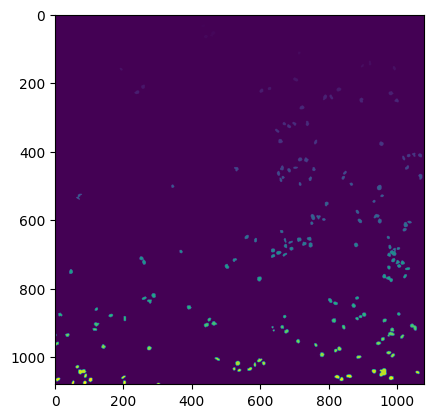

In [132]:
from cellpose import models

segmentation_model = models.CellposeModel(gpu=True, model_type="C:/Users/rz200/Documents/development/distillCellSegTrack/pipeline/CellPose_models/Nuclei_Hoechst")
n_channels = [[0, 0]]
n_mask_array, n_flows, n_styles = segmentation_model.eval(combined_images[0][1], channels=n_channels)

plt.imshow(n_mask_array)

In [ ]:
import wandb
wandb.login()

run = wandb.init(
    # Set the project where this run will be logged
    project="Cellpose Cell Segmentation Distillation",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": 0.1
    })

In [293]:
#expand the lists of data by 1 dimension to make it 4D
tiled_images_input_train_clean_exp = tiled_images_input_train_clean.unsqueeze(1)
tiled_intermediate_outputs_train_clean_exp = tiled_intermediate_outputs_train_clean
tiled_flows_and_cellprob_output_train_clean_exp = tiled_flows_and_cellprob_output_train_clean

train_images_tiled, val_images_tiled, train__upsamples, val__upsamples, train_ys, val_ysm = train_test_split(tiled_images_input_train_clean_exp,tiled_intermediate_outputs_train_clean_exp, tiled_flows_and_cellprob_output_train_clean_exp, test_size=0.1, random_state=42)

train_dataset = ImageDataset(train_images_tiled, train__upsamples, train_ys)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

validation_dataset = ImageDataset(val_images_tiled, val__upsamples, val_ysm)
validation_loader = DataLoader(validation_dataset, batch_size=8, shuffle=True)

In [286]:
print(tiled_images_input_train_clean_exp.shape)

torch.Size([64, 1, 224, 224])


In [299]:
torch.manual_seed(4)

from resnet_archi import CPnet

#unet = UNet(encChannels=(2,32,64,128,256),decChannels=(256,128,64,32),nbClasses=3) #it's not a problem to train it with 2 channels as anyway it is just the same channel repeated twice for the nuclei model but that may make more parameters to train so we may want to chang ethat
#unet = unet.to('cuda:0')
unet = CPnet(nbase=[1,32,64,128,256], nout=3, sz=3,
                residual_on=True, style_on=True, 
                concatenation=False, mkldnn=False)
unet = unet.to('cuda:0')

In [317]:
loss_fn = KD_loss(alpha=2, beta=1)
optimiser = torch.optim.Adam(unet.parameters(), lr=0.1)

scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=30, gamma=0.1)

for epoch in range(10000):
    #we really need to change to 'best IoU' saves the model
    #print(scheduler.get_last_lr())
    unet, train_y_32_loss, train_map_loss, train_IoU, val_y_32_loss, val_map_loss, val_IoU = trainEpoch(unet, train_loader, validation_loader, loss_fn, optimiser, scheduler=scheduler, epoch_num=epoch, device='cuda:0')
    #wandb.log({"epoch": epoch, "train_y_32_loss": train_y_32_loss, "train_map_loss": train_map_loss, "val_y_32_loss": val_y_32_loss, "val_map_loss": val_map_loss, "val_IoU": val_IoU})
    torch.save(unet.state_dict(), "resnet_nuc_9")

Epoch:  0 Train 32 loss:  3.8855415420839563 Train map loss 0.18145836889743805 Train IoU 0.5423476824071258 Val 32 loss:  0.12721797823905945 Val map loss:  0.0853816345334053 Val IoU:  0.18808284401893616 Time:  2.038717031478882
Epoch:  1 Train 32 loss:  0.6224890461598989 Train map loss 0.12978255655616522 Train IoU 0.2123426804319024 Val 32 loss:  0.042313456535339355 Val map loss:  0.07559463381767273 Val IoU:  0.6475942134857178 Time:  1.6977379322052002
Epoch:  2 Train 32 loss:  0.09680430345179047 Train map loss 0.10933618294075131 Train IoU 0.7592692598700523 Val 32 loss:  0.02746712602674961 Val map loss:  0.06217138469219208 Val IoU:  0.5860000252723694 Time:  1.7162582874298096
Epoch:  3 Train 32 loss:  0.1223882154590683 Train map loss 0.08875154796987772 Train IoU 0.27055112831294537 Val 32 loss:  0.08206835389137268 Val map loss:  0.06803557276725769 Val IoU:  0.545505702495575 Time:  1.711186408996582
Epoch:  4 Train 32 loss:  0.34379392117261887 Train map loss 0.08092

KeyboardInterrupt: 

In [351]:
#now let's import the model and insert it back

from resnet_archi import CPnet
model = CPnet(nbase=[1,32,64,128,256], nout=3, sz=3,
                residual_on=True, style_on=True, 
                concatenation=False, mkldnn=False)
model.load_model("/Users/rz200/Documents/development/distillCellSegTrack/pipeline/resnet_nuc_8", device=torch.device('cuda:0'))

x = np.array([combined_images[0][1]])
#if there is only one channel, copy the channel to make it 2 channels
if x.shape[0] == 1:
    x = np.repeat(x, 2, axis=0)
if x.ndim < 4:
    x = x[np.newaxis,...]
x = x.transpose((0,2,3,1))
masks, styles, dP, cellprob, p = run_cp(x,model,channels=1,rescale=1.283732,return_training_data=False)

shape: (1, 1080, 1080, 2)


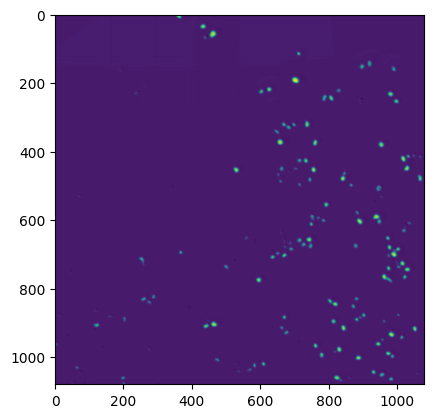

In [362]:
plt.imshow(dP[1])

In [ ]:
#WE ARE TRYIBNG THE TEST_IMAGES
from resnet_archi import CPnet
model = CPnet(nbase=[1,32,64,128,256], nout=3, sz=3,
                residual_on=True, style_on=True, 
                concatenation=False, mkldnn=False)

#directory = "/Users/rz200/Documents/development/distillCellSegTrack/pipeline/CellPose_models/Nuclei_Hoechst"
#cpnet = resnet_torch.CPnet(nbase=[2,32,64,128,256],nout=3,sz=3)
#cpnet.load_model(directory)

model.load_model("/Users/rz200/Documents/development/distillCellSegTrack/pipeline/resnet_nuc_6", device=torch.device('cuda:0'))
#model.to_device('cuda:0')


In [ ]:
norm_test_image = normalize_un(test_images[0][100:356,100:356])

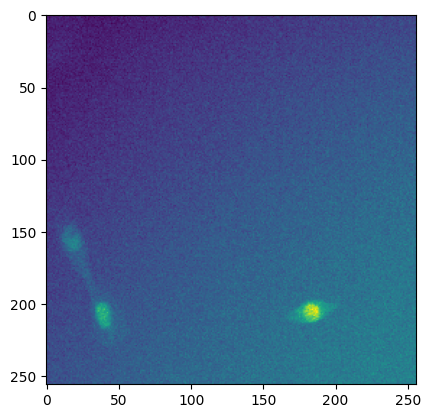

In [ ]:
plt.imshow(norm_test_image)

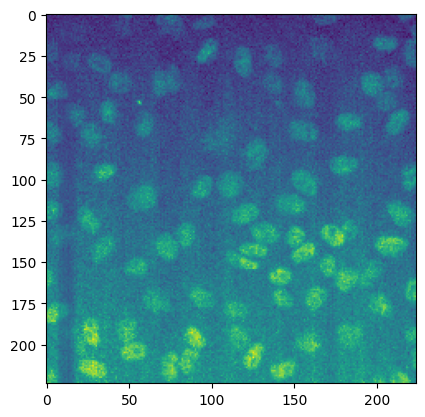

In [ ]:
plt.imshow(train_images_tiled_first[0][0])

In [ ]:
T0_32, pred, style = model(torch.from_numpy(train_images_tiled_first[0].squeeze(0)).unsqueeze(0).unsqueeze(0))

In [ ]:
test_img = np.expand_dims(test_images[2],0)
print(test_img.shape)
image_t = transforms.normalize_img(test_img)

IMG, ysub, xsub, Ly, Lx = transforms.make_tiles(image_t, bsize=224, 
                                                augment=True, tile_overlap=0.1)
ny, nx, nchan, ly, lx = IMG.shape
IMG = np.reshape(IMG, (ny*nx, nchan, ly, lx))
batch_size = 1
niter = int(np.ceil(IMG.shape[0] / batch_size))
nout = 3 + 32*False
y = np.zeros((IMG.shape[0], nout, ly, lx))
styles = []

preds = []

for k in range(niter):
    irange = np.arange(batch_size*k, min(IMG.shape[0], batch_size*k+batch_size))
    T0_32, pred, style = model(torch.from_numpy(train_images_tiled_first[0].squeeze(0)).unsqueeze(0).unsqueeze(0))
    preds.append(pred)

(1, 1080, 1080)


In [ ]:
print(len(preds))

100


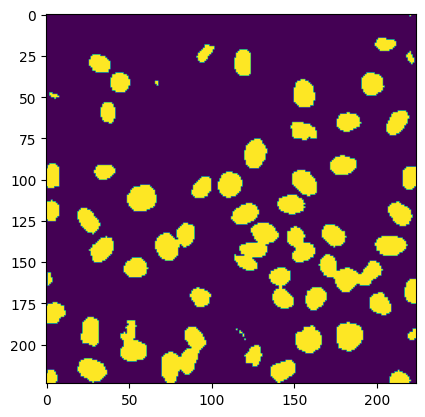

In [ ]:
plt.imshow(pred[0][2].detach().cpu().numpy()>0)

In [ ]:
print(norm_test_image)

[[0.05797968 0.03646145 0.0938434  ... 0.14883443 0.20023909 0.21876868]
 [0.06156605 0.08188882 0.03945009 ... 0.24447101 0.17872086 0.20980275]
 [0.05379558 0.08308428 0.0125523  ... 0.1273162  0.23670054 0.20621638]
 ...
 [0.25523013 0.19187089 0.24865511 ... 0.42438733 0.46921698 0.4363419 ]
 [0.23251644 0.19426181 0.18828452 ... 0.41004184 0.43813509 0.38015541]
 [0.2964734  0.24925284 0.22952779 ... 0.48953975 0.46025105 0.44411237]]


In [ ]:
print(len(pred[0]))

3


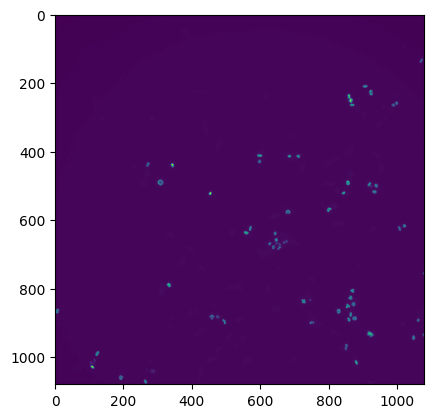

In [ ]:
plt.imshow(test_images[0])

In [ ]:
print(np.unique(pred[0][2].detach().cpu().numpy()))

[-6.150293  -6.141741  -6.1390905 ...  3.9957242  4.0525723  4.0620885]


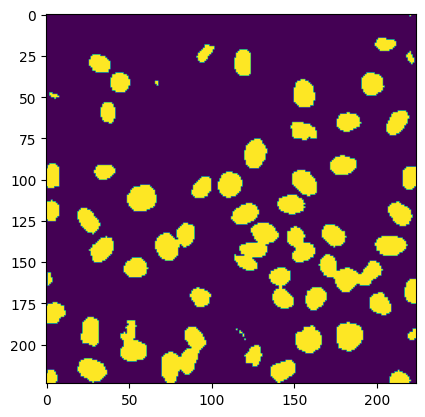

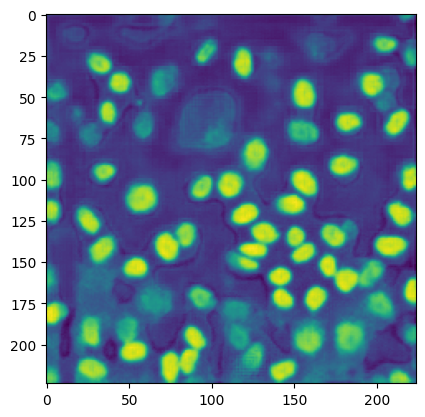

In [ ]:
plt.imshow(pred[0][2].cpu().detach().numpy())

In [ ]:
print(pred.shape)
pred_t = torch.transpose(pred, 1, 3)
print(pred_t.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 224, 224, 3])


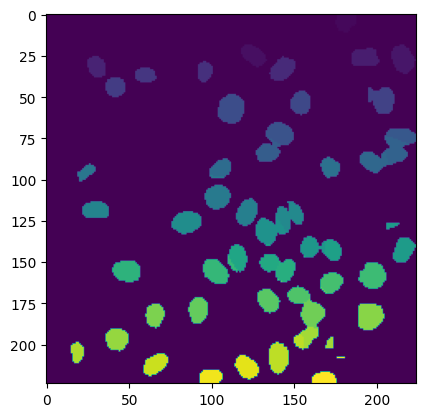

In [ ]:
from cellpose.utils import get_masks_unet

masks = get_masks_unet(pred_t[0], cell_threshold=5, boundary_threshold=0)
plt.imshow(masks)

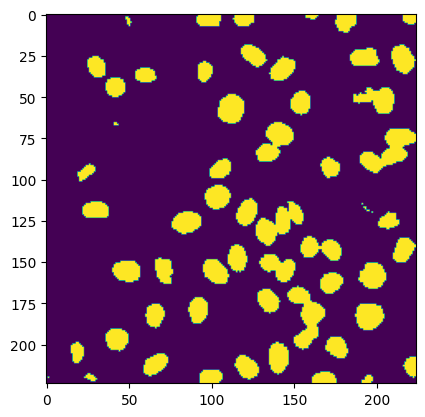

In [ ]:
plt.imshow(pred_t.detach().cpu().numpy()[0][:,:,2]>0)

In [ ]:
print(pred_t[0].shape[-1]>2)

True


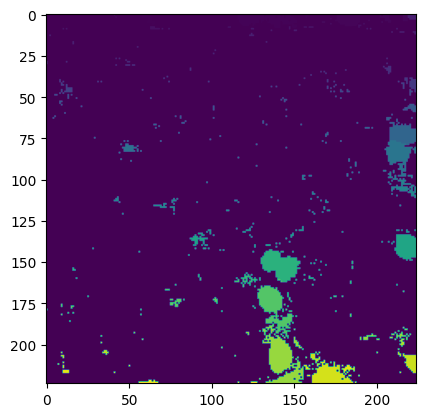

In [ ]:
plt.imshow(masks)

In [ ]:
wandb.finish()


In [ ]:
best_IoU = 0
best_seed = None
for i in range(10000):
    print(i)
    seed = np.random.randint(0,1000000)
    torch.manual_seed(seed)

    unet = UNet(encChannels=(1,32,64,128,256),decChannels=(256,128,64,32),nbClasses=3) #it's not a problem to train it with 2 channels as anyway it is just the same channel repeated twice for the nuclei model but that may make more parameters to train so we may want to chang ethat
    unet = unet.to('cuda:0')
    
    unet, train_y_32_loss, train_map_loss, val_y_32_loss, val_map_loss, val_IoU = trainEpoch(unet, train_loader, validation_loader, loss_fn, optimiser, scheduler=scheduler, epoch_num=epoch, device='cuda:0', progress = False)

    if val_IoU > best_IoU:
        best_IoU = val_IoU
        best_seed = seed
        print('New best IoU: ', best_IoU, 'with seed: ', best_seed)

0


c:\Users\rz200\Anaconda3\envs\cellpose\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


New best IoU:  0.36745397402690005 with seed:  235135
1
New best IoU:  0.37705233693122864 with seed:  978500
2
New best IoU:  0.6026265116838309 with seed:  438763
3
4
5
New best IoU:  0.6617291248761691 with seed:  953817
6
7
8
9
10
11
12
13
14
15
16
New best IoU:  0.663033494582543 with seed:  950612
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
New best IoU:  0.6910819823925312 with seed:  323386
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
New best IoU:  0.6942715782385606 with seed:  335394
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116


KeyboardInterrupt: 

In [ ]:
print(best_seed) #335394

335394


In [ ]:
from pynvml import *

def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")


def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

print_gpu_utilization()

GPU memory occupied: 3740 MB.


In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

21

In [ ]:
test_image = test_images[2]
print(test_image)

[[ 684  631  638 ...  753  817  820]
 [ 702  705  740 ...  797  742  892]
 [ 600  762  684 ...  798  860  836]
 ...
 [ 978  978 1010 ... 1302 1429 1526]
 [1069 1034  998 ... 1406 1379 1518]
 [1045 1094 1027 ... 1482 1506 1396]]


In [ ]:
pred = unet(torch.from_numpy(test_image).unsqueeze(0).to('cuda:0'))

TypeError: can't convert np.ndarray of type numpy.uint16. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [ ]:
print(np.unique(pred[2].cpu().detach().numpy())>0.5)

[False False False ...  True  True  True]


In [ ]:
print(test_images[0][0])

[[0.06265198 0.0615593  0.06406784 ... 0.04560005 0.04469205 0.04493829]
 [0.06482194 0.06226723 0.06179015 ... 0.04570778 0.04373788 0.04706208]
 [0.06134384 0.06263658 0.06440642 ... 0.04656961 0.04778541 0.04472283]
 ...
 [0.07094709 0.07240912 0.07311705 ... 0.06091293 0.06028194 0.05874296]
 [0.07304011 0.07125489 0.07050078 ... 0.06086675 0.05922004 0.0618517 ]
 [0.0697159  0.07351719 0.07420973 ... 0.06040506 0.05977408 0.06168241]]


NameError: name 'test_images' is not defined

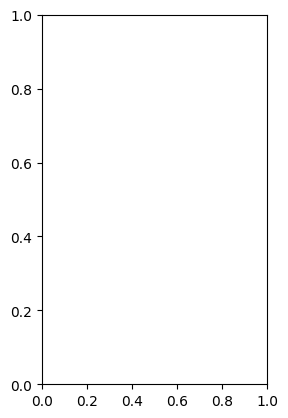

In [ ]:
plt.subplot(1,2,1)
plt.imshow(test_images[2][0])
plt.subplot(1,2,2)
plt.imshow(pred[2].cpu().detach().numpy()[0][2]>0.5)
plt.show()

In [ ]:
#save the model
torch.save(unet.state_dict(), "unet_nuclei_hoechst_test_12")

In [329]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
%load_ext autoreload
%autoreload 2

from unet_instance_2_chans import UNetModel as UNet_2chans

model = UNet_2chans(encChannels=(1,32,64,128,256),decChannels=(256,128,64,32),nbClasses=3)
model.load_weights("unet_U2Os_Tub_Hoechst_test_14")
model.set_device('cuda')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
print(combined_images[0][0].shape)

(1080, 1080)


In [ ]:
print(combined_images[0][0].shape)

(1080, 1080)


image shape (1080, 1080)
tiles (1, 2, 224, 224)
tiles (1, 2, 224, 224)
tiles (1, 2, 224, 224)
tiles (1, 2, 224, 224)
tiles (1, 2, 224, 224)
tiles (1, 2, 224, 224)
tiles (1, 2, 224, 224)
tiles (1, 2, 224, 224)
tiles (1, 2, 224, 224)
tiles (1, 2, 224, 224)
tiles (1, 2, 224, 224)
tiles (1, 2, 224, 224)
tiles (1, 2, 224, 224)
tiles (1, 2, 224, 224)
tiles (1, 2, 224, 224)
tiles (1, 2, 224, 224)
tiles (1, 2, 224, 224)
tiles (1, 2, 224, 224)
tiles (1, 2, 224, 224)
tiles (1, 2, 224, 224)
tiles (1, 2, 224, 224)
tiles (1, 2, 224, 224)
tiles (1, 2, 224, 224)
tiles (1, 2, 224, 224)
tiles (1, 2, 224, 224)
tiles (1, 2, 224, 224)
tiles (1, 2, 224, 224)
tiles (1, 2, 224, 224)
tiles (1, 2, 224, 224)
tiles (1, 2, 224, 224)
tiles (1, 2, 224, 224)
tiles (1, 2, 224, 224)
tiles (1, 2, 224, 224)
tiles (1, 2, 224, 224)
tiles (1, 2, 224, 224)
tiles (1, 2, 224, 224)
(3, 1080, 1080)
(1080, 1080, 3)
(3, 1080, 2)
(1080, 1080, 2)
reasse (1080, 1080)
ggggg


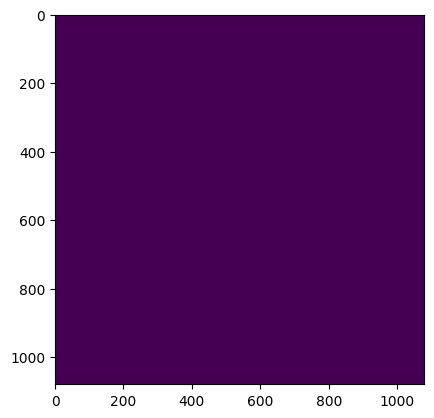

In [ ]:
predictions = model.predict(normalize_un(combined_images[0][0]),normalize=True,channels=[0,0])
plt.imshow(predictions[0][4])

In [ ]:
print(len(np.unique(predictions[0][4])))

1


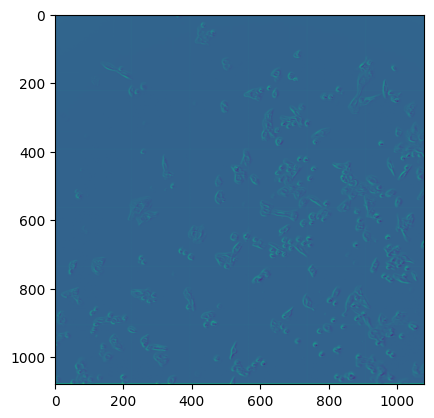

In [ ]:
plt.imshow(predictions[0][2][1][0])

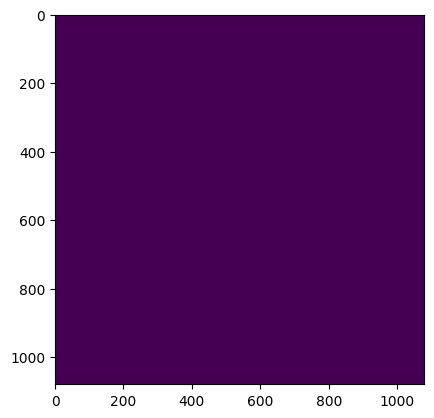

In [ ]:
plt.imshow(predictions[0][1])


552


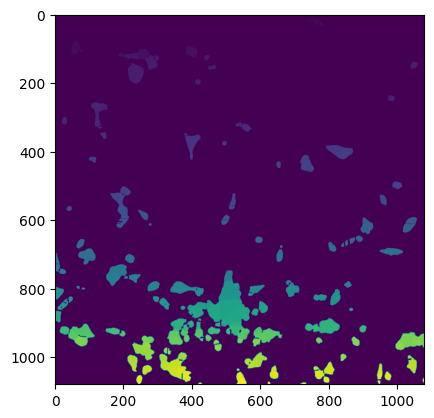

405


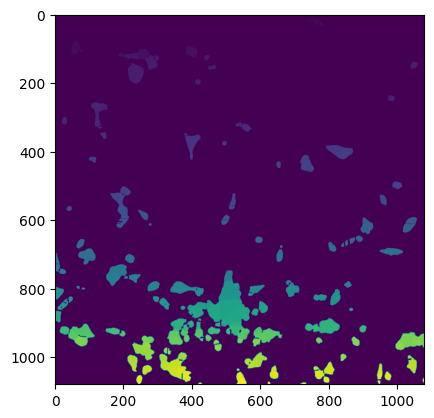

In [ ]:
#instance_segmentation, outputs, dP, reassembled_image, instance_segmentation_2
print(np.unique(predictions[0][4])[-1])

plt.imshow(predictions[0][4]);plt.show()

#for each unique pixel value in predictions[0][4], if the number of pixels with that value is less than 20, set them to 0
instance_seg = predictions[0][4].copy()
unique_values = np.unique(instance_seg[1:])
counts = np.bincount(instance_seg.flatten())
indices_to_zero = unique_values[counts[unique_values] < 40]
instance_seg[np.isin(instance_seg, indices_to_zero)] = 0

print(len(np.unique(instance_seg)))
plt.imshow(instance_seg)

In [107]:
#trying Cellpose to compare
from cellpose import models

segmentation_model = models.CellposeModel(gpu=True, model_type="C:/Users/rz200/Documents/development/distillCellSegTrack/pipeline/CellPose_models/U2OS_Tub_Hoechst")
n_channels = [[1, 1]]
n_mask_array, n_flows, n_styles = segmentation_model.eval(combined_images[1], channels=n_channels)

rescale: 0.89789855
normalize: True
invert: False
flow_threshold: 0.4
cellprob_threshold: 0.0
net_avg: False
tile: True
tile_overlap: 0.1
resample: True
interp: True
min_size: 15
do_3D: False
anisotropy: None
stitch_threshold: 0.0
augment: False
compute_masks: True
(1, 1080, 1080, 2)
nbase [2, 32, 64, 128, 256]
nbase -1 256


130


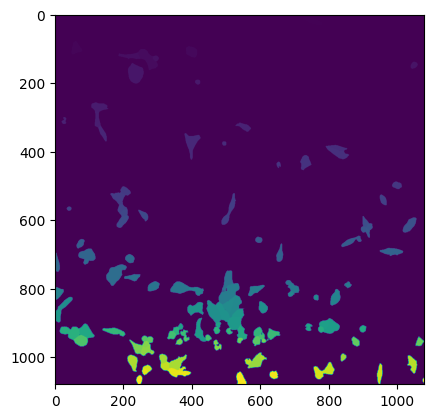

In [ ]:
plt.imshow(n_mask_array)
print(len(np.unique(n_mask_array)))

In [ ]:
print(n_mask_array.shape, instance_seg.shape)

n_mask_array_binary= np.where(n_mask_array>0, 1, 0)
instance_seg_binary = np.where(instance_seg>0, 1, 0)

intersection = np.logical_and(n_mask_array_binary, instance_seg_binary).sum()
union = np.logical_or(n_mask_array_binary, instance_seg_binary).sum()
iou = intersection / (union)
print(iou)

(1080, 1080) (1080, 1080)
0.6221277291683702


NameError: name 'n_mask_array' is not defined

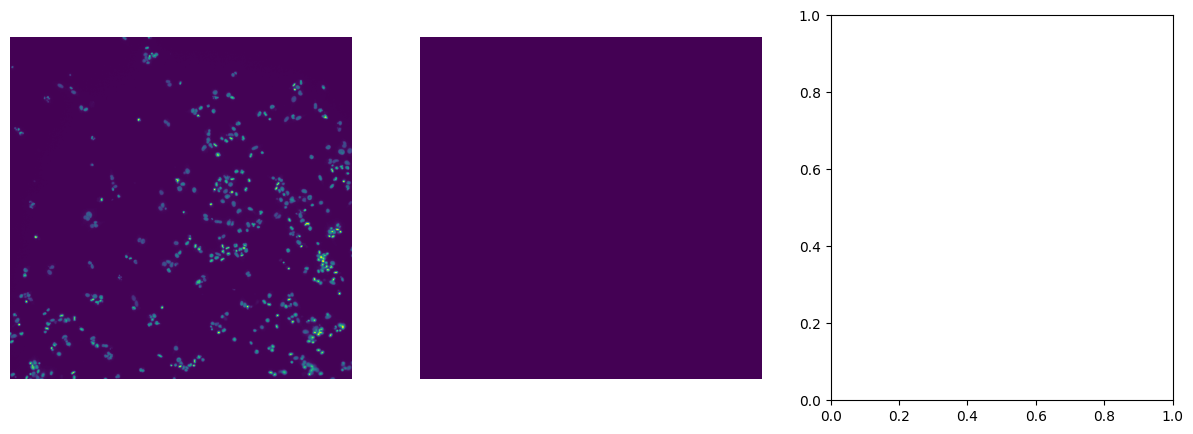

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(combined_images[0])
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(predictions[0][1])
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(n_mask_array)
plt.axis('off')
plt.show()

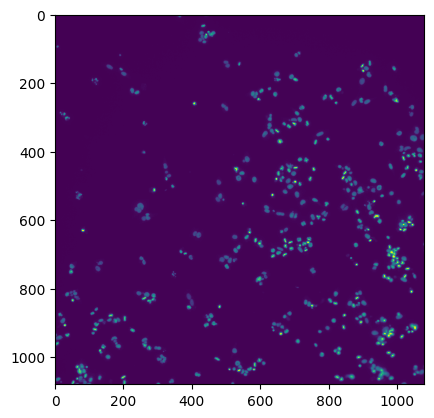

In [ ]:
plt.imshow(combined_images[0])

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

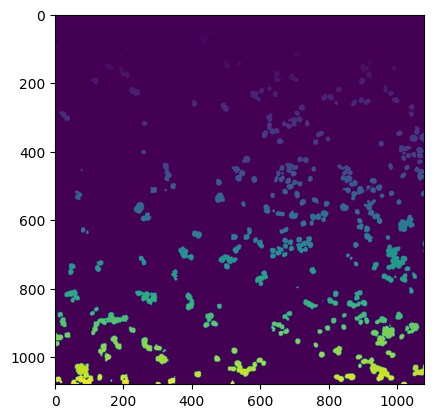

In [ ]:
plt.imshow(predictions[0][4])
print(np.unique(predictions[0][4]))

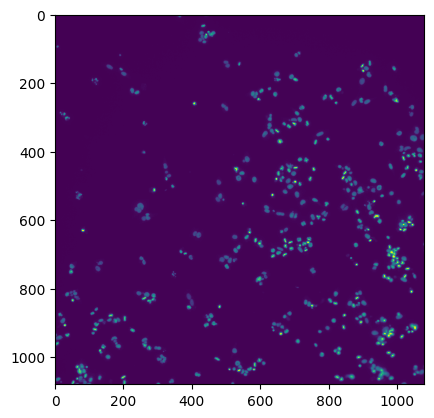

In [ ]:
plt.imshow(combined_images[0])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84]


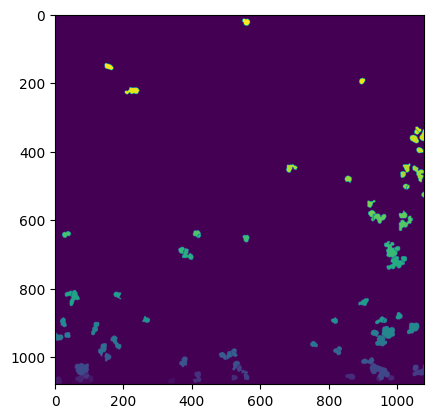

In [ ]:
plt.imshow(predictions[0][0])
print(np.unique(predictions[0][0]))

In [ ]:
print(predictions[0][3])

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84]


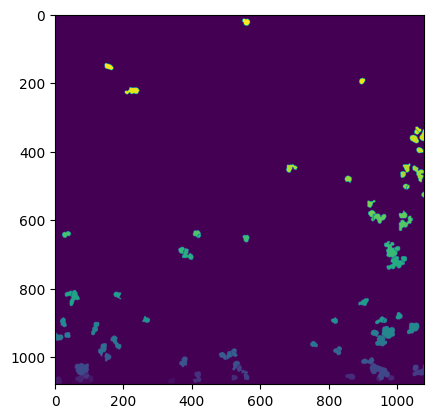

In [ ]:
plt.imshow(predictions[0][0])
print(np.unique(predictions[0][0]))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135]


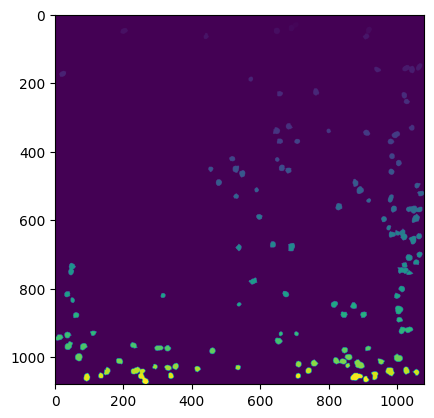

In [ ]:
plt.imshow(predictions[0][1][0])
print(np.unique(predictions[0][1][0]))

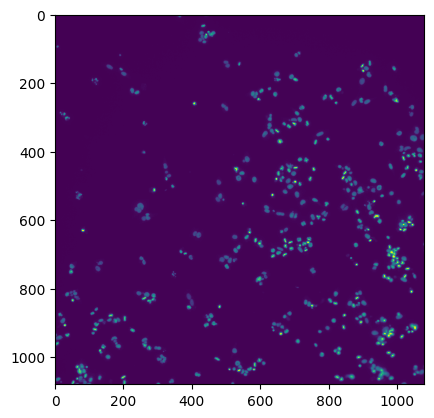

In [ ]:
plt.imshow(combined_images[0])

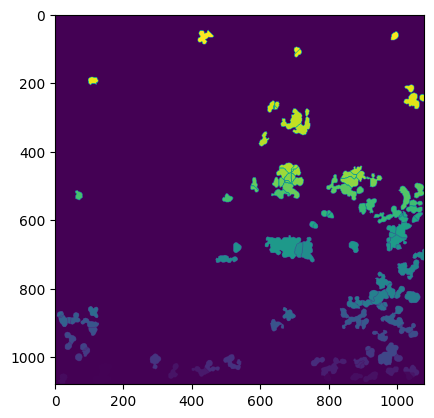

In [ ]:
plt.imshow(predictions[0][0])

In [ ]:
print(np.unique(predictions[0][0]))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131]


In [ ]:
from cellpose import dynamics

test_image = combined_images[1]
test_image = np.array([test_image,test_image])

#image = transforms.normalize_img(test_image)

tiles, ysub, xsub, Ly, Lx = transforms.make_tiles(test_image, bsize=224, 
                                        augment=True, tile_overlap=0.1)

# Predicting
ny, nx, nchan, ly, lx = tiles.shape
tiles = np.reshape(tiles, (ny*nx, nchan, ly, lx))
batch_size = 1
niter = int(np.ceil(tiles.shape[0] / batch_size))
nout = 3 + 32*False
y_unet = np.zeros((tiles.shape[0], nout, ly, lx))


for k in range(niter):
    irange = np.arange(batch_size*k, min(tiles.shape[0], batch_size*k+batch_size))
    #print('IMG irange',tiles[irange].shape)
    _, _, y0_unet = unet(torch.from_numpy(tiles[irange]).to('cuda:0'))
    y0_unet = y0_unet.cpu().detach().numpy()
    y_unet[irange] = y0_unet.reshape(len(irange), y0_unet.shape[-3], y0_unet.shape[-2], y0_unet.shape[-1])

yf = transforms.average_tiles(y_unet, ysub, xsub, Ly, Lx)

In [ ]:
yf = yf[:,:test_image.shape[1],:test_image.shape[2]]

shape = test_image.shape
dP = np.zeros((2, 1, int(shape[1]*1), int(shape[2]*1)), np.float32)
cellprob = np.zeros((1, int(shape[1]*1), int(shape[2]*1)), np.float32)

yf_t = yf.transpose(1,2,0)
print(yf.shape)
cellprob[0] = yf_t[:,:,2]
cellprob = cellprob[0]
dP[:, 0] = yf[:2,:,:]

# Post processing
reassembled_image = 1 / (1 + np.exp(-cellprob))
reassembled_image = reassembled_image > 0.5
instance_segmentation = mod._binary_to_instance(reassembled_image)

outputs = dynamics.compute_masks(yf_t[:,:,:2].transpose((2,0,1)), yf_t[:,:,2], niter=156, cellprob_threshold=0,
                                                    flow_threshold=0.4, interp=True, resize=None, 
                                                    use_gpu=True, device="cuda:0")

(3, 1080, 1080)


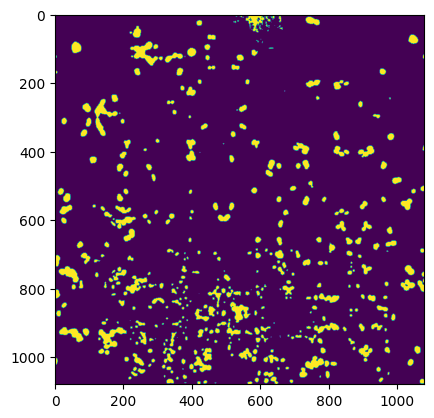

In [ ]:

cp_mask = cellprob > 0.0 
plt.imshow(cp_mask) 

In [ ]:
print(dP.shape)

(2, 1, 1080, 1080)


In [ ]:
dP = dP.squeeze(1)
dP = 1/(1+np.exp(-dP))

In [ ]:
from cellpose.dynamics import steps2D, get_masks

shape = np.array(dP.shape[1:]).astype(np.int32)
p = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
p = np.array(p).astype(np.float32)
inds = np.array(np.nonzero(np.abs(dP[0])>1e-3)).astype(np.int32).T
p = steps2D(p, dP.astype(np.float32), inds, niter)
print(inds.shape)

(1166318, 2)


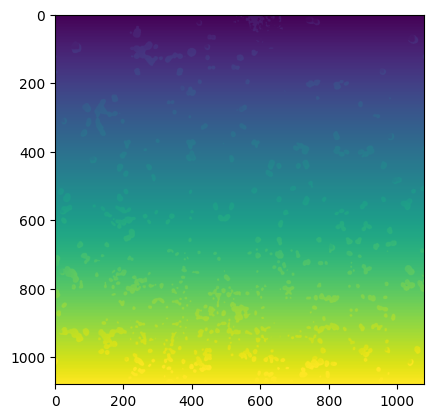

In [ ]:
plt.imshow(p[0])

In [ ]:
from cellpose import utils

mask = get_masks(p, iscell=cp_mask)
mask = utils.fill_holes_and_remove_small_masks(mask, min_size=15)

In [ ]:
print(np.unique(mask))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

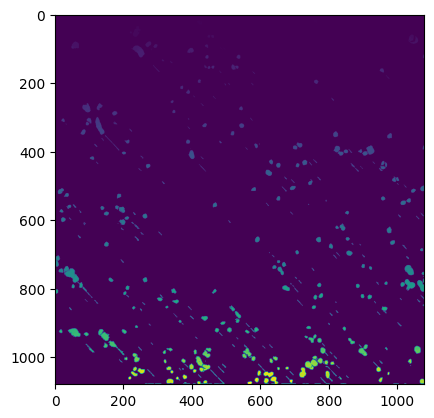

In [ ]:
plt.imshow(mask)

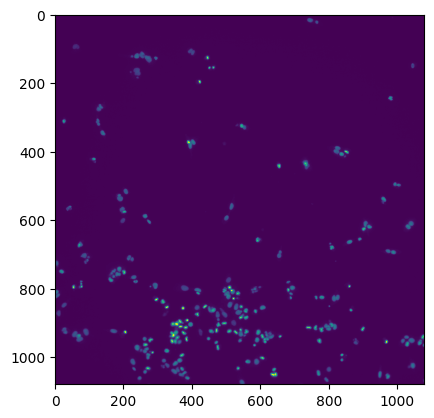

In [ ]:
plt.imshow(combined_images[1])

In [ ]:
#need to clean mask
#need to show real image to compare

In [ ]:
(np.unique(instance_segmentation))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166])

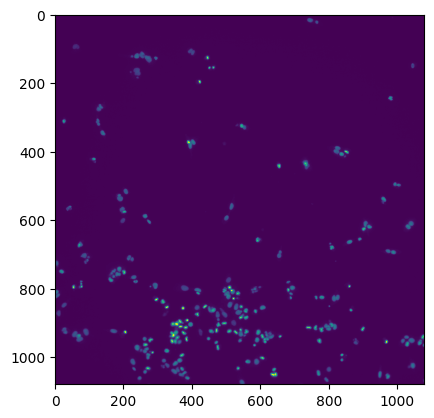

In [ ]:
plt.imshow(combined_images[1])

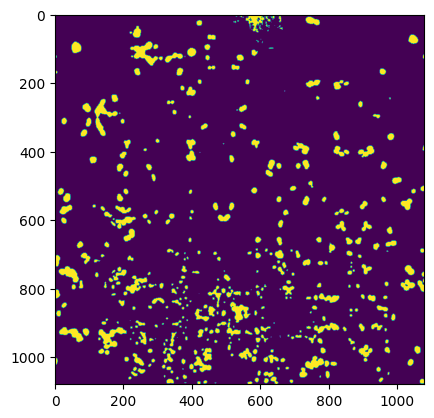

In [ ]:
plt.imshow(cellprob>0)

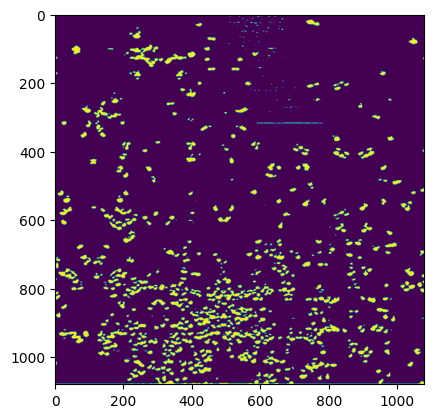

In [ ]:
from unet_instance_2_chans import UNetModel as UNet_2chans

mod = UNet_2chans(encChannels=(2,32,64,128,256),decChannels=(256,128,64,32),nbClasses=3)

reassembled_image = 1 / (1 + np.exp(-(dP[0][0])))
plt.imshow(reassembled_image < 0.5)
reassembled_image = reassembled_image < 0.5
instance_segmentation = mod._binary_to_instance(reassembled_image)



[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

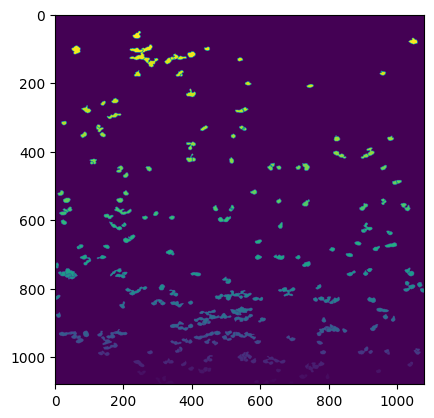

In [ ]:
plt.imshow(instance_segmentation)
print(np.unique(instance_segmentation))

[-17.11002  -16.979692 -16.297554 ...  13.175228  13.465097  13.646183]


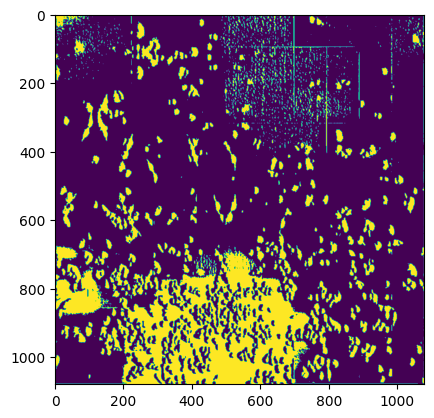

In [ ]:
plt.imshow(dP[1][0]<0)
print(np.unique(dP[1][0]))

[-17.11002  -16.979692 -16.297554 ...  13.175228  13.465097  13.646183]


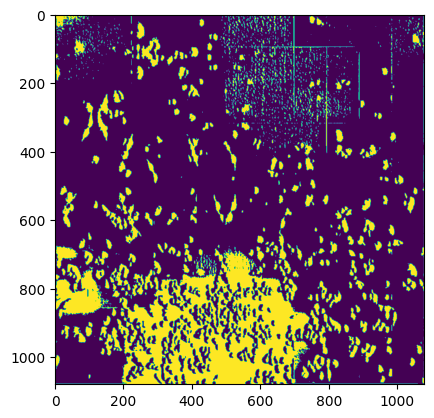

In [ ]:
plt.imshow(dP[1][0]<0)
print(np.unique(dP[1][0]))

In [ ]:
print(len(predictions[0]))

3


In [ ]:
instance_segmentation, outputs, dP = predictions[0]

In [ ]:
print(dP.shape)

(2, 1, 1080, 1080)


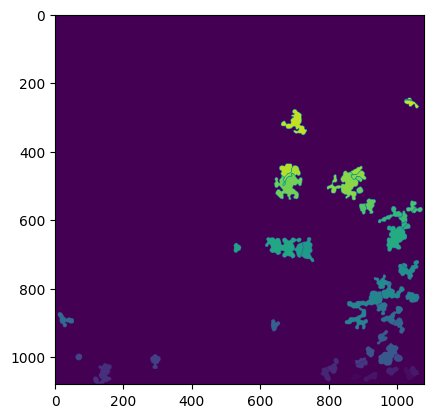

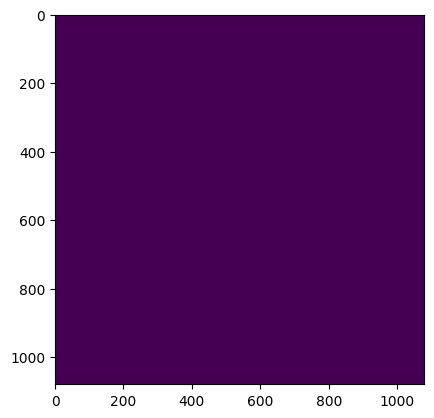

In [ ]:
plt.imshow(instance_segmentation); plt.show()
plt.imshow(dP[0][0]); plt.show()

In [ ]:
print(output.shape)

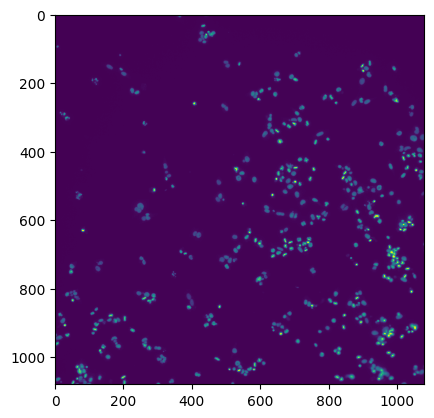

In [ ]:
plt.imshow(combined_images[0])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57]


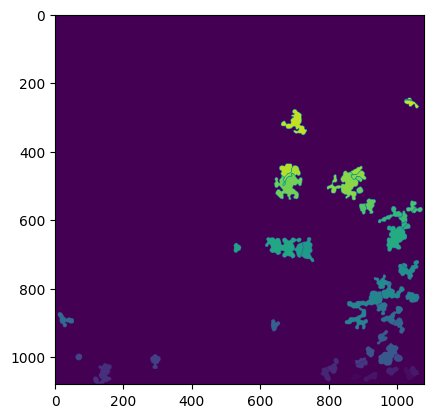

In [ ]:
print(np.unique(prediction))
plt.imshow(prediction[0])